# Backprop своими руками

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import framework as fw
import optim

---

В следующих двух секциях — игрушечные примеры регрессии и классификации на синтезированных данных. 

# Линейная регрессия

In [5]:
n = 2000

X = np.random.randn(n, 10)
true_w = np.random.randn(10, 1)
Y = np.dot(X, true_w).reshape(n)# + np.random.randn()/5

### Модель

In [6]:
model = fw.Sequential(
    fw.Linear(10, 1),
    # fw.LeakyReLU(),
    # fw.BatchNorm(8),
    # fw.Dropout(0.2),
    # fw.Linear(8, 1)
)

epochs = 35
batch_size = 10
learning_rate = 1e-1
criterion = fw.MSE()
optimizer = optim.Adam(model.parameters(), learning_rate)

### Обучение

Epoch: 0, Loss: 0.43188197837331543
Epoch: 1, Loss: 0.25922737113462296
Epoch: 2, Loss: 0.20167176588813182
Epoch: 3, Loss: 0.17263282865807375
Epoch: 4, Loss: 0.15596105010930753
Epoch: 5, Loss: 0.14580906294630158
Epoch: 6, Loss: 0.13671470157512275
Epoch: 7, Loss: 0.1311734523159791
Epoch: 8, Loss: 0.12645192812462178
Epoch: 9, Loss: 0.12307447553494384
Epoch: 10, Loss: 0.11946189451441153
Epoch: 11, Loss: 0.1169600986496306
Epoch: 12, Loss: 0.11454128795859954
Epoch: 13, Loss: 0.11274650495076177
Epoch: 14, Loss: 0.11068937762050801
Epoch: 15, Loss: 0.10923191092910788
Epoch: 16, Loss: 0.10804735394549007
Epoch: 17, Loss: 0.10652264910302586
Epoch: 18, Loss: 0.10544785085533302
Epoch: 19, Loss: 0.10444547813160918
Epoch: 20, Loss: 0.10349290951628153
Epoch: 21, Loss: 0.10287731272920425
Epoch: 22, Loss: 0.10225018225841745
Epoch: 23, Loss: 0.10140624096391979
Epoch: 24, Loss: 0.10102130057806512
Epoch: 25, Loss: 0.10064784620912677
Epoch: 26, Loss: 0.10022079387009875
Epoch: 27, Lo

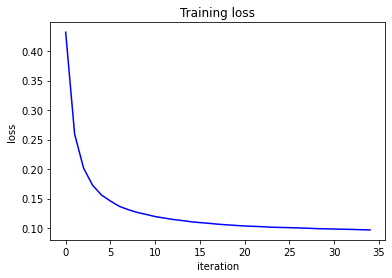

In [7]:
history = []
losses = []

for i in range(epochs):
    for x, y_true in optim.loader(X, Y, batch_size):
        y_true = y_true.reshape(-1, 1)
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        # optim.SGD(model.parameters(),
        #     model.grad_parameters(),
        #     learning_rate)
        optimizer.step(model.parameters(),
            model.grad_parameters())
        losses.append(loss)
        
    print('Epoch: {}, Loss: {}'.format(i, np.mean(losses)))
    history.append(np.mean(losses))

plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

# Логистическая регрессия

Тестирование классификации (`CrossEntropy` и `SoftMax`).

Возьмем в качестве датасета точки из двух гауссиан на плоскости.

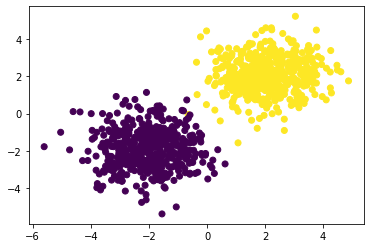

In [8]:
n = 500

X1 = np.random.randn(n, 2) + np.array([2, 2])
X2 = np.random.randn(n, 2) + np.array([-2, -2])
X = np.vstack([X1, X2])

Y = np.concatenate([np.ones(n), np.zeros(n)])[:, None]
Y = np.hstack([Y, 1-Y])

plt.scatter(X[:,0], X[:,1], c=Y[:,0])
plt.show()

Переменная`y` в формате one-hot: у каждого вектора все нули, кроме одной единицы.


### Модель


In [13]:
model = fw.Sequential(
    fw.Linear(2, 8),
    fw.ReLU(),
    # fw.BatchNorm(8),
    fw.Linear(8, 2),
    fw.SoftMax()
)

epochs = 50
batch_size = 16
learning_rate = 1e-1
criterion = fw.CrossEntropy()
optimizer = optim.Adam(model.parameters(), learning_rate)

### Обучение

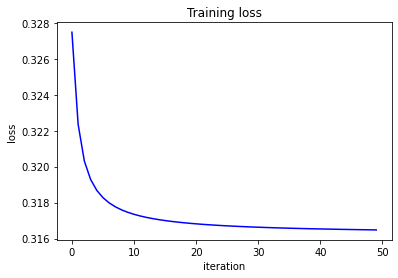

In [14]:
history = []
losses = []
for i in range(epochs):
    for x, y_true in optim.loader(X, Y, batch_size):
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        optimizer.step(model.parameters(), model.grad_parameters())
        losses.append(loss)
    history.append(np.mean(losses))
    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

# MNIST

In [15]:
import os
from sklearn.datasets import fetch_openml

if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r', allow_pickle=True) as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    X = mnist.data / 255.0
    y = mnist.target
    np.savez('mnist.npz', X=X, y=y)

Разделите датасет на train и validation.

In [16]:
indices = np.random.permutation(X.shape[0])
train_size = int(X.shape[0]*0.9)
train_idx, val_idx = indices[:train_size], indices[train_size:]

X_train, Y_train = X[train_idx,:], y[train_idx]
X_val, Y_val = X[val_idx,:], y[val_idx]

Переведём лейблы в one-hot

In [17]:
targets_train = np.array(list(map(int, Y_train)))
one_hot_targets_train = np.eye(10, dtype=int)[targets_train]

targets_val = np.array(list(map(int, Y_val)))
one_hot_targets_val = np.eye(10, dtype=int)[targets_val]

Определим функцию отрисовки кривых обучения и оценки точности работы модели

In [18]:
def plot_training(train, val, text='Loss'):
    plt.figure(figsize=(8,6))
    plt.title(text, fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel(text, fontsize=14)
    plt.plot(train, label='Train {}'.format(text))
    plt.plot(val, label='Val {}'.format(text))
    plt.legend(fontsize=14)
    plt.tick_params(axis='both', labelsize=14)
    plt.xticks(range(len(train)))
    # plt.xlim([0, 19])
    plt.grid()
    plt.show()

Определим функцию подсчёта точности работы модели

In [19]:
def accuracy_score(true_values, predictions):
  return (true_values == predictions).sum() / len(true_values)

Зададим архитектуру

In [45]:
# model = fw.Sequential(
#     fw.Linear(784, 512),
#     fw.BatchNorm(512),
#     fw.LeakyReLU(),
#     fw.Linear(512, 128),
#     fw.BatchNorm(128),
#     fw.Linear(128, 10),
#     fw.SoftMax(),
# )

model = fw.Sequential(
    fw.Linear(784, 512),
    fw.LeakyReLU(),
    fw.BatchNorm(512),
    fw.Linear(512, 512),
    fw.LeakyReLU(),
    fw.BatchNorm(512),
    # fw.Linear(512, 128),
    # fw.BatchNorm(512),
    fw.Linear(512, 10),
    fw.SoftMax(),
)

criterion = fw.CrossEntropy()
batch_size = 128
epoch = 15
optimizer = optim.Adam(model.parameters(), lr=3e-4)

Цикл обучения

In [46]:
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []
for i in range(epoch):
    acc_train = []
    acc_own = []
    acc_val = []
    train_loss = []
    val_loss = []
    model.train()
    for x, y_true in optim.loader(X_train, one_hot_targets_train, batch_size):
        # y_true.reshape(-1, 1)
        y_pred = model.forward(x)
        y_pred_for_acc = np.argmax(y_pred, axis=1)
        y_true_for_acc = np.argmax(y_true, axis=1)
        loss_train = criterion.forward(y_pred, y_true)
        acc_train.append(accuracy_score(y_true_for_acc, y_pred_for_acc))
        # acc_own.append(accuracy_score2(y_true_for_acc, y_pred_for_acc))
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        optimizer.step(model.parameters(), model.grad_parameters())
        train_loss.append(loss_train)

    if epoch % 1 == 0:
        model.eval()
        for x, y_true in optim.loader(X_val, one_hot_targets_val, batch_size):
            y_pred = model.forward(x)
            loss_val = criterion.forward(y_pred, y_true)
            val_loss.append(loss_val)
            y_pred_for_acc = np.argmax(y_pred, axis=1)
            y_true_for_acc = np.argmax(y_true, axis=1)
            acc_val.append(accuracy_score(y_true_for_acc, y_pred_for_acc))
            
        print('--Train--')
        print('Epoch: {}, Accuracy: {}, Loss {}'.format(i, np.mean(acc_train), np.mean(train_loss)))
        # print(np.mean(acc_own))
        print('--Validation--')
        print('Epoch: {}, Accuracy: {}, Loss {}'.format(i, np.mean(acc_val), np.mean(val_loss)))
        print()
        train_losses.append(np.mean(train_loss))
        val_losses.append(np.mean(val_loss))
        train_accuracy.append(np.mean(acc_train))
        val_accuracy.append(np.mean(acc_val))

--Train--
Epoch: 0, Accuracy: 0.9190014367816092, Loss 1.5480499424004226
--Validation--
Epoch: 0, Accuracy: 0.9532928719008265, Loss 1.5072730849689473

--Train--
Epoch: 1, Accuracy: 0.9595641058147397, Loss 1.5014789876704553
--Validation--
Epoch: 1, Accuracy: 0.9678719008264463, Loss 1.4930819845354233

--Train--
Epoch: 2, Accuracy: 0.9682851588911426, Loss 1.4927279089741825
--Validation--
Epoch: 2, Accuracy: 0.9721720041322314, Loss 1.4889764362688003

--Train--
Epoch: 3, Accuracy: 0.9732346602434077, Loss 1.487886159648706
--Validation--
Epoch: 3, Accuracy: 0.9743026859504132, Loss 1.4867967577753547

--Train--
Epoch: 4, Accuracy: 0.9757120520622042, Loss 1.4854271456864625
--Validation--
Epoch: 4, Accuracy: 0.9763558884297521, Loss 1.484793284330367

--Train--
Epoch: 5, Accuracy: 0.9773918187964842, Loss 1.48372251385258
--Validation--
Epoch: 5, Accuracy: 0.9763688016528926, Loss 1.484787226184143

--Train--
Epoch: 6, Accuracy: 0.9787810598377282, Loss 1.4823050570556662
--Valid

Выведем кривые обучения (потери по эпохам)

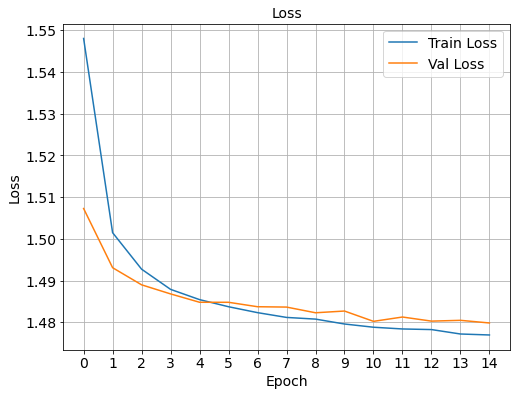

In [47]:
plot_training(train_losses, val_losses)

Выведем точность по эпохам

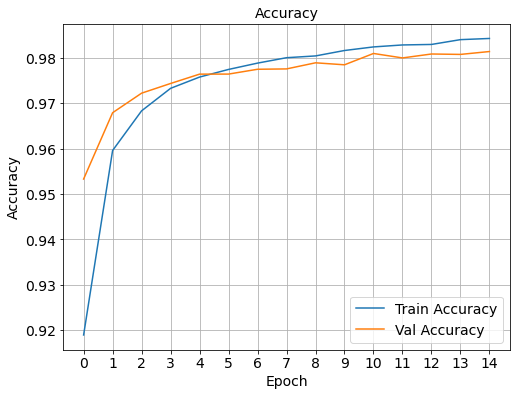

In [48]:
plot_training(train_accuracy, val_accuracy, text='Accuracy')